In [1]:
!pip install efficientnet
!pip install iterative-stratification
!pip install gdown

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
if not os.path.isfile('model_effnet_bo_087.h5'):
    !gdown https://drive.google.com/uc?id=1FXF1HymYbRf3OlThMTXAa74TRup3AhD_

In [3]:
import numpy as np
import pandas as pd
import pydicom
import cv2
import tensorflow as tf
import multiprocessing
from math import ceil, floor
import keras
import keras.backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model, load_model
from keras.utils import Sequence
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
import efficientnet.keras as efn 
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import matplotlib.pyplot as plt

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [4]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    return bsb_img

def _read(path, SHAPE):
    dcm = pydicom.dcmread(path)
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(SHAPE)
    return img

In [5]:
base_model =  efn.EfficientNetB0(weights = 'imagenet', include_top = False, \
                                 pooling = 'avg', input_shape = (256, 256, 3))

x = base_model.output
x = Dropout(0.125)(x)
output_layer = Dense(6, activation = 'sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer = Adam(lr = 0.0001), 
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [6]:
model.load_weights('model_effnet_bo_087.h5')

In [7]:
img_data = _read('ID_000012eaf.dcm', (256, 256))
img_data.shape

(256, 256)

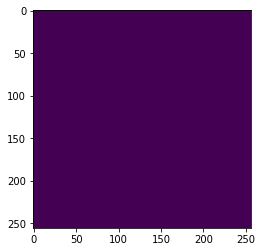

In [14]:
plt.imshow(img_data)

In [35]:
X = np.empty((1, 256,256, 3))
X[0] = img_data
X.shape

(1, 256, 256, 3)

In [36]:
preds = model.predict(X)
preds

array([[0.02540314, 0.00152788, 0.0010443 , 0.0023855 , 0.00326541,
        0.00998502]], dtype=float32)

In [37]:
preds.shape

(1, 6)